In [2]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np

import os
import sys
__file__ = './'
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))

# os.path.dirname(__file__)获取当前文件的绝对路径
# os.path.join(xx,'..')在后面追加..，相当于进入上一级目录
# os.path.abspath(xx)获取绝对路径
# sys.path.append()将其加入系统路径当中

import MSA
import LINK

In [3]:
# read data
my_link = pd.read_excel(r'D:\004_PhD_Dissertation\Paper_Code\Part3\input_network\small_net.xlsx', sheet_name='link_info')
my_link['I'] = 0
my_node = pd.read_excel(r'D:\004_PhD_Dissertation\Paper_Code\Part3\input_network\small_net.xlsx', sheet_name='node_info')
my_link['name'] = my_link['from'].astype('str') +'-'+ my_link['to'].astype('str')
my_demand = pd.read_excel(r'D:\004_PhD_Dissertation\Paper_Code\Part3\input_network\small_net.xlsx', sheet_name='demand_info')
print(my_demand)

# set parameter
origin_zone = ['r1']
destination_zone = ['s1']
theta_1 = 1 # path 
# theta_2 = 0.5 # mode
miu_in = 25
miu_out = 30
lamda_0_hailing = 2 #2 RMB/minute
lamda_0_PR = 20 # RMB
lamda_0_transit = 5
N_hailing = 500
lamda_0_auto = LINK.compute_lamda_0_auto(fuel_consumption=8.5)

df = []
theta_2_lst = np.arange(0.01, 0.8, 0.025) 
for theta_2 in theta_2_lst:
    result = MSA.assignment(my_link= my_link, my_node= my_node, my_demand= my_demand,
                        origin_zone= origin_zone, destination_zone= destination_zone,
                        miu_in= miu_in, miu_out= miu_out,
                        lamda_0_auto= lamda_0_auto,
                        lamda_0_hailing= lamda_0_hailing,
                        lamda_0_transit= lamda_0_transit,
                        lamda_0_PR= lamda_0_PR,
                        theta_1= theta_1, theta_2= theta_2,
                        N_hailing= N_hailing, A=2, maximum_iter=300)
    df.append(result)

# system cost
total_cost = []
for item in df:
    flow_set = item[2].tail(item[6])
    cost = sum(abs(flow_set['path_cost']) * flow_set['path_flow'])
    total_cost.append(cost)

# OD cost
def od_cost(path, od):
    cost = sum(abs(path[path['OD_pair'] == od]['path_cost']) * path[path['OD_pair'] == od]['path_flow'])
    return cost

od_1_cost = []
od_2_cost = []
od_3_cost = []
od_4_cost = []
for i in range(len(df)):
    flow_set = df[i][2].tail(df[i][6])
    od_1_cost.append(od_cost(flow_set, 'r1-s1'))
    od_2_cost.append(od_cost(flow_set, 'r1-s2'))
    od_3_cost.append(od_cost(flow_set, 'r2-s1'))
    od_4_cost.append(od_cost(flow_set, 'r2-s2'))

# mode share
PR_logit = [df[i][4].tail(df[i][7]).iloc[0]['mode_logit'] for i in range(len(df))]
RT_logit = [df[i][4].tail(df[i][7]).iloc[1]['mode_logit'] for i in range(len(df))]
auto_logit = [df[i][4].tail(df[i][7]).iloc[2]['mode_logit'] for i in range(len(df))]
bus_logit = [df[i][4].tail(df[i][7]).iloc[3]['mode_logit'] for i in range(len(df))]

# path_flow
path_1_flow = [df[i][2].tail(df[i][6]).iloc[0]['path_flow'] for i in range(len(df))]
path_2_flow = [df[i][2].tail(df[i][6]).iloc[1]['path_flow'] for i in range(len(df))]
path_3_flow = [df[i][2].tail(df[i][6]).iloc[2]['path_flow'] for i in range(len(df))]
path_4_flow = [df[i][2].tail(df[i][6]).iloc[3]['path_flow'] for i in range(len(df))]

# path_duration
path_1_duration = [df[i][2].tail(df[i][6]).iloc[0]['path_duration'] for i in range(len(df))]
path_2_duration = [df[i][2].tail(df[i][6]).iloc[1]['path_duration'] for i in range(len(df))]
path_3_duration = [df[i][2].tail(df[i][6]).iloc[2]['path_duration'] for i in range(len(df))]
path_4_duration = [df[i][2].tail(df[i][6]).iloc[3]['path_duration'] for i in range(len(df))]

# path_cost
path_1_cost = [abs(df[i][2].tail(df[i][6]).iloc[0]['path_cost']) for i in range(len(df))]
path_2_cost = [abs(df[i][2].tail(df[i][6]).iloc[1]['path_cost']) for i in range(len(df))]
path_3_cost = [abs(df[i][2].tail(df[i][6]).iloc[2]['path_cost']) for i in range(len(df))]
path_4_cost = [abs(df[i][2].tail(df[i][6]).iloc[3]['path_cost']) for i in range(len(df))]

# ride-hailing vehicle number
n_idle = [df[i][5].tail(1).iloc[0]['n_idle'] for i in range(len(df))]
waiting_hailing = [df[i][5].tail(1).iloc[0]['wait_time'] for i in range(len(df))]

# convert to dataframe
dfx = pd.DataFrame({
        'scale': theta_2_lst,
        'n_idle': n_idle,
        'waiting time': waiting_hailing,
        'total_cost': total_cost,
        'auto_logit': auto_logit,
        'bus_logit': bus_logit,
        'PR_logit': PR_logit,
        'RT_logit': RT_logit,
        'path_1_flow': path_1_flow,
        'path_2_flow': path_2_flow,
        'path_3_flow': path_3_flow,
        'path_4_flow': path_4_flow,
        'path_1_cost': path_1_cost,
        'path_2_cost': path_2_cost,
        'path_3_cost': path_3_cost,
        'path_4_cost': path_4_cost,
        'path_1_duration': path_1_duration,
        'path_2_duration': path_2_duration,
        'path_3_duration': path_3_duration,
        'path_4_duration': path_4_duration,})

  OD_pair  demand
0   r1-s1    1000
0.6517
['path-1', 'path-2', 'path-3', 'path-4']
['auto', 'P&R', 'transit', 'R&T']
Iteration = 1, gap = 0.026726687331870606,
the number of idle_hailing:500.0
Iteration = 2, gap = 0.1811359992898224,
the number of idle_hailing:403.5897131785679
Iteration = 3, gap = 0.09026530215192183,
the number of idle_hailing:401.2804655543015
Iteration = 4, gap = 0.060129801197807364,
the number of idle_hailing:401.21351564873174
Iteration = 5, gap = 0.045076109428496394,
the number of idle_hailing:401.2103911485847
Iteration = 6, gap = 0.036048233127575775,
the number of idle_hailing:401.2094805061855
Iteration = 7, gap = 0.030031767141398276,
the number of idle_hailing:401.2088678876338
Iteration = 8, gap = 0.025735499212757442,
the number of idle_hailing:401.20841075443116
Iteration = 9, gap = 0.02251405258731925,
the number of idle_hailing:401.20805598221955
Iteration = 10, gap = 0.020008985599783025,
the number of idle_hailing:401.20777263384764
Iteration = 1

In [4]:
dfx

,scale,n_idle,waiting time,total_cost,auto_logit,bus_logit,PR_logit,RT_logit,path_1_flow,path_2_flow,path_3_flow,path_4_flow,path_1_cost,path_2_cost,path_3_cost,path_4_cost,path_1_duration,path_2_duration,path_3_duration,path_4_duration
0,0.010,401.206644,5.706095,102696.386352,0.249948,0.250243,0.249760,0.250049,249.953801,249.772533,250.228204,250.045462,108.031540,141.787127,67.999659,93.037202,35.208159,124.408243,143.913467,119.205208
1,0.035,401.157162,5.706430,102546.276729,0.249822,0.250847,0.249162,0.250168,249.819113,249.160881,250.849313,250.170693,107.796139,141.584721,68.015226,93.047648,35.131440,124.360558,143.950827,119.230213
2,0.060,401.109444,5.706754,102401.798173,0.249700,0.251449,0.248567,0.250284,249.694628,248.564839,251.452605,250.287928,107.570806,141.389790,68.029891,93.057314,35.058002,124.313800,143.986023,119.253345
3,0.085,401.063227,5.707067,102259.147852,0.249581,0.252048,0.247975,0.250396,249.573739,247.971452,252.053322,250.401487,107.348779,141.197232,68.044287,93.066702,34.985642,124.267286,144.020574,119.275815
4,0.110,401.018502,5.707370,102118.305137,0.249466,0.252644,0.247385,0.250505,249.456457,247.380723,252.651445,250.511374,107.130035,141.007026,68.058412,93.075813,34.914352,124.221007,144.054475,119.297621
5,0.135,400.975242,5.707663,101979.227918,0.249354,0.253238,0.246798,0.250610,249.342696,246.792623,253.247025,250.617657,106.914499,140.819120,68.072274,93.084653,34.844108,124.174958,144.087744,119.318778
6,0.160,400.934074,5.707942,101843.487184,0.249245,0.253830,0.246213,0.250711,249.239064,246.210226,253.834963,250.715748,106.705998,140.635668,68.085322,93.092714,34.776156,124.128807,144.119058,119.338068
7,0.185,400.893925,5.708214,101708.007442,0.249140,0.254419,0.245631,0.250809,249.132876,245.627710,254.424961,250.814453,106.497117,140.452475,68.098609,93.100969,34.708080,124.083170,144.150947,119.357826
8,0.210,400.855186,5.708477,101574.190346,0.249038,0.255006,0.245052,0.250904,249.030059,245.047754,255.012494,250.909693,106.291277,140.271458,68.111643,93.108964,34.640996,124.037745,144.182229,119.376961
9,0.235,400.817802,5.708731,101441.975454,0.248940,0.255591,0.244475,0.250995,248.930412,244.470303,255.597687,251.001597,106.088347,140.092542,68.124440,93.116714,34.574860,123.992536,144.212941,119.395510


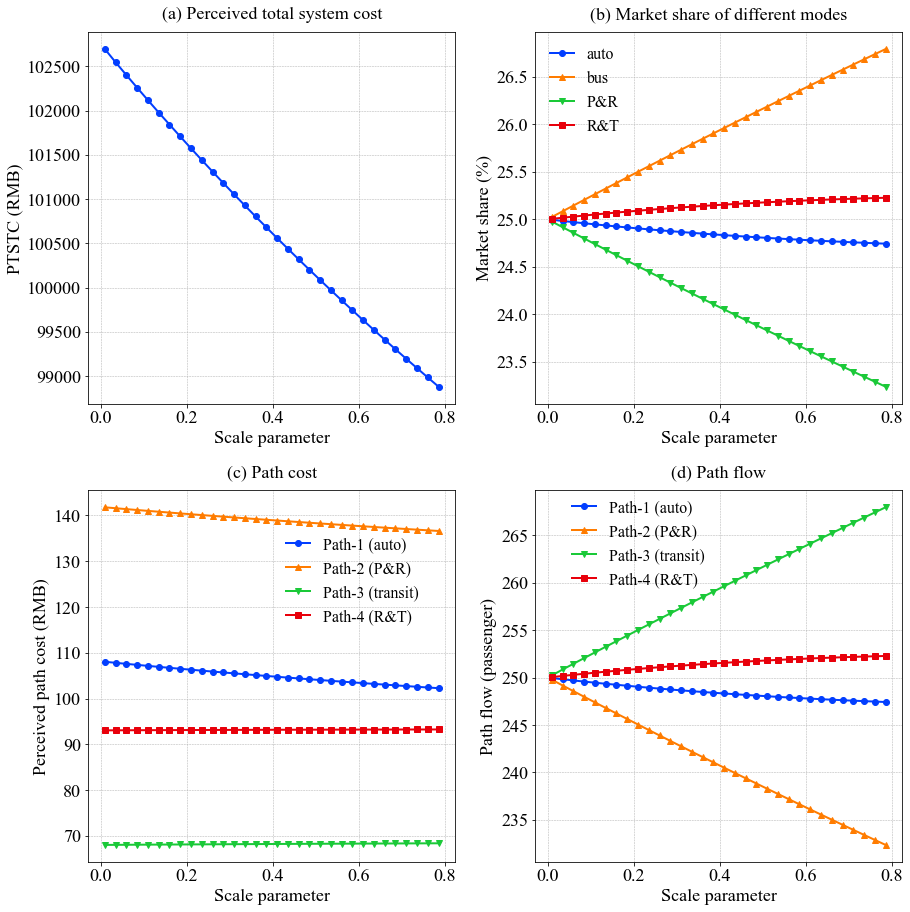

In [6]:
import seaborn as sns
sns.set_palette("bright", 10)
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 18

fig = plt.figure(figsize=(13,13))
markers = ['o','^','v','s','h','D','p','<','>']

ax = plt.subplot(2,2,1)
ax.grid(ls = '--', lw = 0.5, zorder = 0)
ax.plot(dfx['scale'], dfx['total_cost'], '-', lw=2, marker='o')
ax.set_xlabel('Scale parameter')
ax.set_ylabel('PTSTC (RMB)')
ax.set_title('(a) Perceived total system cost', fontsize=18, loc='center', y=1.02)

ax = plt.subplot(2,2,2)
ax.grid(ls = '--', lw = 0.5, zorder = 0)
ax.plot(dfx['scale'], dfx['auto_logit']*100, '-', lw=2, marker=markers[0], label='auto')
ax.plot(dfx['scale'], dfx['bus_logit']*100, '-', lw=2, marker=markers[1], label='bus')
ax.plot(dfx['scale'], dfx['PR_logit']*100, '-', lw=2, marker=markers[2], label='P&R')
ax.plot(dfx['scale'], dfx['RT_logit']*100, '-', lw=2, marker=markers[3], label='R&T')
ax.set_xlabel('Scale parameter')
ax.set_ylabel('Market share (%)')
ax.legend(loc='best', fontsize=16, frameon=False, handlelength=1.5) #, bbox_to_anchor=(0.7,0.7)
ax.set_title('(b) Market share of different modes', fontsize=18, loc='center', y=1.02,)

ax = plt.subplot(2,2,3)
ax.grid(ls = '--', lw = 0.5, zorder = 0)
ax.plot(dfx['scale'], dfx['path_1_cost'], '-', lw=2, marker='o',label='Path-1 (auto)')
ax.plot(dfx['scale'], dfx['path_2_cost'], '-', lw=2, marker='^',label='Path-2 (P&R)')
ax.plot(dfx['scale'], dfx['path_3_cost'], '-', lw=2, marker='v',label='Path-3 (transit)')
ax.plot(dfx['scale'], dfx['path_4_cost'], '-', lw=2, marker='s',label='Path-4 (R&T)')
ax.set_xlabel('Scale parameter')
ax.set_ylabel('Perceived path cost (RMB)')
ax.legend(loc='best', fontsize=16, frameon=False, handlelength=1.5,bbox_to_anchor = (0.5,0.6)) #,bbox_to_anchor = (0.6,0.4)
ax.set_title('(c) Path cost', fontsize=18, loc='center', y=1.02)

ax = plt.subplot(2,2,4)
ax.grid(ls = '--', lw = 0.5, zorder = 0)
ax.plot(dfx['scale'], dfx['path_1_flow'], '-', lw=2, marker='o',label='Path-1 (auto)')
ax.plot(dfx['scale'], dfx['path_2_flow'], '-', lw=2, marker='^',label='Path-2 (P&R)')
ax.plot(dfx['scale'], dfx['path_3_flow'], '-', lw=2, marker='v',label='Path-3 (transit)')
ax.plot(dfx['scale'], dfx['path_4_flow'], '-', lw=2, marker='s',label='Path-4 (R&T)')
ax.set_xlabel('Scale parameter')
ax.set_ylabel('Path flow (passenger)')
ax.legend(loc='best', fontsize=16, frameon=False, handlelength=1.5, bbox_to_anchor = (0.5,0.7),)  
ax.set_title('(d) Path flow', fontsize=18, loc='center', y=1.02)

plt.tight_layout()
plt.show()